In [1]:
import os
import glob
import cv2
#import numba as nb
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
from time import time
#from numba import jit
import seaborn as sns
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
from skimage.io import imread
from PIL import Image
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img
np.random.seed(111)
color = sns.color_palette()
%matplotlib inline

# Input data files are available in the "../input/" directory.

import os
print(os.listdir("/"))

# Any results you write to the current directory are saved as output.

['$Recycle.Bin', '$WinREAgent', 'BIOS', 'Da', 'Data Science', 'DB2', 'dbauto', 'Documents and Settings', 'Drivers', 'DumpStack.log', 'DumpStack.log.tmp', 'hiberfil.sys', 'in7390', 'inst7390', 'Intel', 'KMPlayer', 'mc', 'OneDriveTemp', 'OSGeo4W64', 'pagefile.sys', 'PerfLogs', 'Photos', 'Program Files', 'Program Files (x86)', 'ProgramData', 'Recovery', 'rtools40', 'Sotwares', 'SQL2019', 'STUDY MODE', 'swapfile.sys', 'System Volume Information', 'Temp', 'Users', 'Windows', 'Wondershare UniConverter']


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import VGG16

In [3]:
# Defining some paths as usual
input_dir = Path('data_300x300/data_300x300')
#data_dir = input_dir / '/STUDY MODE/My stuff/College/Sem 4/DAB402 Capstone Project/Image class/archive/input/data_300x300/data_300x300'

data_dir = input_dir

***This dataset contains images and labels of feline reticulocytes (an immature red blood cell without a nucleus, having a granular or reticulated appearance when suitably stained). The dataset was created using equipment that is easily accessible to veterinarians: a standard laboratory microscope and two types of cameras: a basic microscope camera and a smartphone camera***

Let's look how the dataset is arranged

In [4]:
os.listdir(data_dir)

['.ipynb_checkpoints',
 'cell_number',
 'images',
 'labels',
 'object-detection-api.ipynb',
 'TEST']

The `images` directory contains the images for training,  the `labels` directory contains the corresponding annotations for the training images and `TEST` contains the test images. How are the annotations done? When you annotate any object with a bounding box, there are certain things that you need to take care of in the annotations. The annotation corresponding to an image should contain the coordinates of the bounding boxes, the height of the image, the width of the image and the label corresponding to that box.  Here is an example of the annotation in our dataset:

```
<annotation>
	<folder>images</folder>
	<filename>000045.jpg</filename>
	<path>/home/vini/Desktop/data_300x300/images/000045.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>300</width>
		<height>300</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>aggregate reticulocyte</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>140</xmin>
			<ymin>115</ymin>
			<xmax>169</xmax>
			<ymax>143</ymax>
		</bndbox>
	</object>
	<object>
		<name>punctate reticulocyte</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>72</xmin>
			<ymin>155</ymin>
			<xmax>103</xmax>
			<ymax>187</ymax>
		</bndbox>
	</object>
	<object>
		<name>erythrocyte</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>184</xmin>
			<ymin>195</ymin>
			<xmax>213</xmax>
			<ymax>228</ymax>
		</bndbox>
	</object>
</annotation>
```

You can see the height and width of the image, the bounding box `bndbox`, the coordinates of the bounding box `xmin, ymin, xmax, ymax`, the label corresponding to that bounding box  given by the node `name` . There are a lot of opensource tools that you can use for annotating datasets but amongst all of them, the simplest and the best one is [labelImg](https://github.com/tzutalin/labelImg). 

## Preprocessing

The annotations are given as `xmls`. The Tensorflow Object detection API accepts data in `TFRecords` format. So, we need to process our annotations

In [5]:
# A function to parse the xmls
def parse_xmls(xml_files):
    data = []
    # Iterate over each file
    for sample in xml_files:
        # Get the xml tree
        tree = ET.parse(sample)

        # Get the root
        root = tree.getroot()

        # Get the members and extract the values
        for member in root.findall('object'):
            # Name of the image file
            filename = root.find('filename').text
            
            # Height and width of the image
            width =  int((root.find('size')).find('width').text)
            height = int((root.find('size')).find('height').text)
            
            # Bounding box coordinates
            bndbox = member.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            xmax = float(bndbox.find('xmax').text)
            ymin = float(bndbox.find('ymin').text)
            ymax = float(bndbox.find('ymax').text)
            
            # label to the corresponding bounding box
            label =  member.find('name').text

            data.append((filename, width, height, label, xmin, ymin, xmax, ymax))
    
    # Create a pandas dataframe
    columns_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    df = pd.DataFrame(data=data, columns=columns_name)

    return df

In [6]:
images = sorted(glob.glob('data_300x300/data_300x300/images/*.jpg'))
xmls = sorted(glob.glob('data_300x300/data_300x300/labels/*.xml'))
print("Total number of images: ", len(images))
print("Total number of xmls: ", len(xmls))

Total number of images:  1086
Total number of xmls:  1086


In [7]:
# Parse the xmls and get the data in a dataframe
df = parse_xmls(xmls)
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,000045.jpg,300,300,aggregate reticulocyte,140.0,115.0,169.0,143.0
1,000045.jpg,300,300,punctate reticulocyte,72.0,155.0,103.0,187.0
2,000045.jpg,300,300,erythrocyte,184.0,195.0,213.0,228.0
3,000058.jpg,300,300,erythrocyte,174.0,65.0,203.0,94.0
4,000058.jpg,300,300,aggregate reticulocyte,120.0,113.0,151.0,143.0


In [8]:
img = cv2.imread("data_300x300/images/000045.jpg",1)

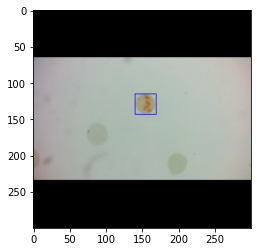

In [9]:
#image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#Show the image with matplotlib

cv2.rectangle(img, pt1=(140,115), pt2=(169,143), color=(0,0,255))
plt.imshow(img)
plt.show()

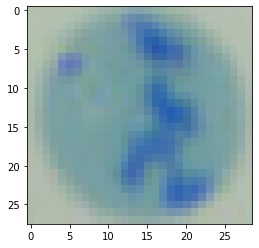

In [10]:
im = Image.open(r"data_300x300/images/000045.jpg")
 
# Size of the image in pixels (size of original image)
# (This is not mandatory)
width, height = im.size
 
# Setting the points for cropped image
#(140,115)(169,143)
left = 140
top = 115
right = 169
bottom = 143
 
# Cropped image of above dimension
# (It will not change original image)
im1 = im.crop((left, top, right, bottom))
plt.imshow(im1)
plt.show()

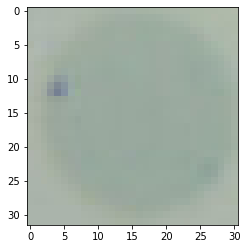

In [11]:
im = Image.open(r"data_300x300/images/000045.jpg")
 
# Size of the image in pixels (size of original image)
# (This is not mandatory)
width, height = im.size
 
# Setting the points for cropped image
#(140,115)(169,143)
#72.0	155.0	103.0	187.0
left = 72
top = 155
right = 103
bottom = 187
 
# Cropped image of above dimension
# (It will not change original image)
im1 = im.crop((left, top, right, bottom))
plt.imshow(im1)
plt.show()

erythrocyte               1982
punctate reticulocyte     1007
aggregate reticulocyte    1001
Name: class, dtype: int64


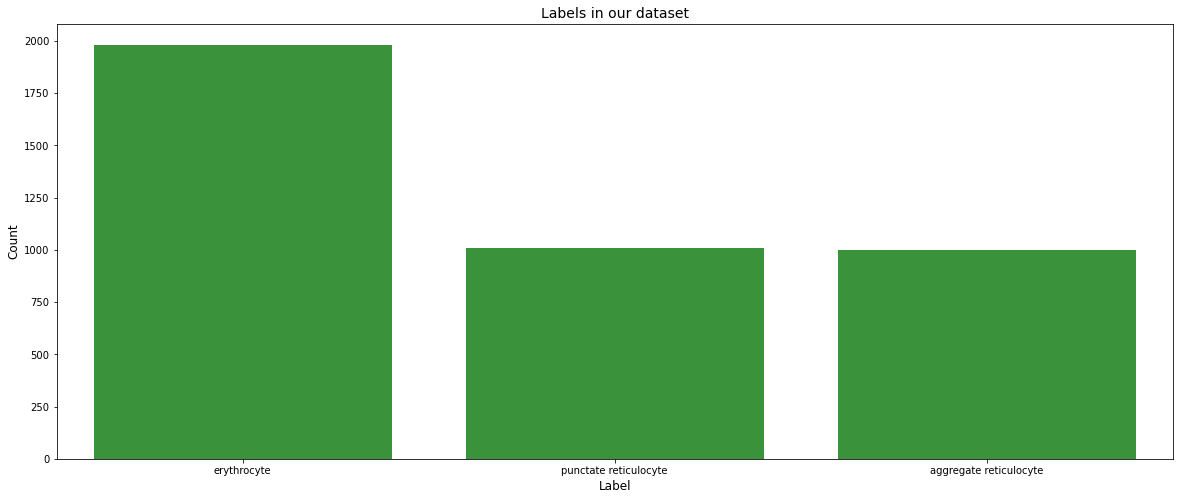

In [12]:
# How many classes do we have for object detection?
label_counts = df['class'].value_counts()
print(label_counts)

plt.figure(figsize=(20,8))
sns.barplot(x=label_counts.index, y= label_counts.values, color=color[2])
plt.title('Labels in our dataset', fontsize=14)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(label_counts.index)), ['erythrocyte', 'punctate reticulocyte', 'aggregate reticulocyte'])
plt.show()

In [13]:
train, valid = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=111)

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
print("Number of training samples: ", len(train))
print("Number of validation samples: ", len(valid))

Number of training samples:  3192
Number of validation samples:  798


In [14]:
train

,filename,width,height,class,xmin,ymin,xmax,ymax
0,001176.jpg,300,300,erythrocyte,23.0,13.0,68.0,54.0
1,000595.jpg,300,300,erythrocyte,246.0,58.0,292.0,105.0
2,000618.jpg,300,300,punctate reticulocyte,210.0,264.0,248.0,300.0
3,001481.jpg,300,300,erythrocyte,154.0,184.0,184.0,213.0
4,001335.jpg,300,300,erythrocyte,169.0,140.0,200.0,176.0
...,...,...,...,...,...,...,...,...
3187,000535.jpg,300,300,aggregate reticulocyte,84.0,155.0,121.0,191.0
3188,001048.jpg,300,300,erythrocyte,133.0,200.0,175.0,243.0
3189,000648.jpg,300,300,erythrocyte,154.0,87.0,195.0,129.0
3190,000710.jpg,300,300,erythrocyte,185.0,19.0,233.0,68.0


In [15]:
data = []
labels = []
bboxes = []
imagePaths = []

In [16]:
train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,001176.jpg,300,300,erythrocyte,23.0,13.0,68.0,54.0
1,000595.jpg,300,300,erythrocyte,246.0,58.0,292.0,105.0
2,000618.jpg,300,300,punctate reticulocyte,210.0,264.0,248.0,300.0
3,001481.jpg,300,300,erythrocyte,154.0,184.0,184.0,213.0
4,001335.jpg,300,300,erythrocyte,169.0,140.0,200.0,176.0


In [17]:
# loop over the rows
for row in train:
	print(row)

filename
width
height
class
xmin
ymin
xmax
ymax


In [18]:
for name, values in train.iteritems():
    print('{name}: {value}'.format(name=name, value=values[0]))

filename: 001176.jpg
width: 300
height: 300
class: erythrocyte
xmin: 23.0
ymin: 13.0
xmax: 68.0
ymax: 54.0


In [19]:
#for i, j in df.iterrows():
#    print(j["filename"])
data = []
labels = []
bboxes = []
imagePaths = []

for i,j in df.iterrows():
    # derive the path to the input image, load the image (in
	# OpenCV format), and grab its dimensions
	imagePath = str("data_300x300/images/" + j["filename"])
	image = cv2.imread(imagePath)
	(h, w) = image.shape[:2]
	# scale the bounding box coordinates relative to the spatial
	# dimensions of the input image
	startX = float(j["xmin"]) / w
	startY = float(j["ymin"]) / h
	endX = float(j["xmax"]) / w
	endY = float(j["xmax"]) / h
        # load the image and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	# update our list of data, class labels, bounding boxes, and
	# image paths
	if j["class"] == "aggregate reticulocyte":
		labels.append(1)
	elif j["class"] == "punctate reticulocyte":
		labels.append(2)
	elif j["class"] == "erythrocyte":
		labels.append(3)
    
	data.append(image)
# 	labels.append(df["class"])
	bboxes.append((startX, startY, endX, endY))
	imagePaths.append(imagePath)

In [20]:
from sklearn.preprocessing import LabelBinarizer

In [21]:
# convert the data, class labels, bounding boxes, and image paths to
# NumPy arrays, scaling the input pixel intensities from the range
# [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)
# perform one-hot encoding on the labels
# lb = LabelBinarizer()
# labels = lb.fit_transform(labels)
# # only there are only two labels in the dataset, then we need to use
# # Keras/TensorFlow's utility function as well
# if len(lb.classes_) == 2:
# 	labels = to_categorical(labels)

In [22]:
from tensorflow.keras.utils import to_categorical

In [23]:
print(labels)

[1 2 3 ... 2 2 2]


In [24]:
split = train_test_split(data, labels, bboxes, imagePaths, test_size=0.20, random_state=42)

In [25]:
# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]
# write the testing image paths to disk so that we can use then
# when evaluating/testing our object detector
print("[INFO] saving testing image paths...")
f = open("test.txt", "w")
f.write("\n".join(testPaths))
f.close()

[INFO] saving testing image paths...


In [26]:
testPaths

array(['data_300x300/images/000885.jpg', 'data_300x300/images/001180.jpg',
       'data_300x300/images/000983.jpg', 'data_300x300/images/000682.jpg',
       'data_300x300/images/001054.jpg', 'data_300x300/images/000198.jpg',
       'data_300x300/images/001709.jpg', 'data_300x300/images/000700.jpg',
       'data_300x300/images/001472.jpg', 'data_300x300/images/000813.jpg',
       'data_300x300/images/001232.jpg', 'data_300x300/images/001492.jpg',
       'data_300x300/images/001149.jpg', 'data_300x300/images/001026.jpg',
       'data_300x300/images/000730.jpg', 'data_300x300/images/000239.jpg',
       'data_300x300/images/000667.jpg', 'data_300x300/images/000824.jpg',
       'data_300x300/images/000710.jpg', 'data_300x300/images/000880.jpg',
       'data_300x300/images/001019.jpg', 'data_300x300/images/000878.jpg',
       'data_300x300/images/000816.jpg', 'data_300x300/images/000835.jpg',
       'data_300x300/images/000875.jpg', 'data_300x300/images/001144.jpg',
       'data_300x300/imag

In [27]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [28]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

In [29]:
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(224, activation="sigmoid")(flatten)
bboxHead = Dense(128, activation="sigmoid")(flatten)
bboxHead = Dense(64, activation="sigmoid")(bboxHead)
bboxHead = Dense(32, activation="sigmoid")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",
	name="bounding_box")(bboxHead)
# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(224, activation="sigmoid")(flatten)
#softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(128, activation="sigmoid")(softmaxHead)
softmaxHead = Dense(64, activation="sigmoid")(softmaxHead)
softmaxHead = Dense(32, activation="sigmoid")(softmaxHead)
#softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(1, activation="softmax",
	name="class_label")(softmaxHead)
# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
	inputs=vgg.input,
	outputs=(bboxHead, softmaxHead))

In [30]:
INIT_LR = 1e-4
NUM_EPOCHS = 40
BATCH_SIZE = 64

In [31]:
# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}
# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(lr=INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

C:\Users\revan\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [32]:
# construct a dictionary for our target training outputs
trainTargets = {
	"class_label": trainLabels,
	"bounding_box": trainBBoxes
}
# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
	"class_label": testLabels,
	"bounding_box": testBBoxes
}

In [33]:
trainTargets

{'class_label': array([1, 1, 2, ..., 2, 2, 3]),
 'bounding_box': array([[0.07333333, 0.28666666, 0.30666667, 0.30666667],
        [0.08      , 0.31      , 0.19333333, 0.19333333],
        [0.78      , 0.68333334, 0.9166667 , 0.9166667 ],
        ...,
        [0.82      , 0.21      , 1.        , 1.        ],
        [0.5466667 , 0.55333334, 0.6566667 , 0.6566667 ],
        [0.5133333 , 0.6766667 , 0.62      , 0.62      ]], dtype=float32)}

In [34]:
# train the network for bounding box regression and class label
# prediction
print("[INFO] training model...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)

[INFO] training model...
Epoch 1/40
50/50 [==============================] - 731s 15s/step - loss: 0.0810 - bounding_box_loss: 0.0810 - class_label_loss: 0.0000e+00 - bounding_box_accuracy: 0.6660 - class_label_accuracy: 0.2566 - val_loss: 0.0697 - val_bounding_box_loss: 0.0697 - val_class_label_loss: 0.0000e+00 - val_bounding_box_accuracy: 0.6504 - val_class_label_accuracy: 0.2281
Epoch 2/40
50/50 [==============================] - 892s 18s/step - loss: 0.0645 - bounding_box_loss: 0.0645 - class_label_loss: 0.0000e+00 - bounding_box_accuracy: 0.6660 - class_label_accuracy: 0.2566 - val_loss: 0.0589 - val_bounding_box_loss: 0.0589 - val_class_label_loss: 0.0000e+00 - val_bounding_box_accuracy: 0.6504 - val_class_label_accuracy: 0.2281
Epoch 3/40
50/50 [==============================] - 882s 18s/step - loss: 0.0571 - bounding_box_loss: 0.0571 - class_label_loss: 0.0000e+00 - bounding_box_accuracy: 0.6660 - class_label_accuracy: 0.2566 - val_loss: 0.0545 - val_bounding_box_loss: 0.0545 -

Epoch 24/40
50/50 [==============================] - 867s 17s/step - loss: 0.0484 - bounding_box_loss: 0.0484 - class_label_loss: 0.0000e+00 - bounding_box_accuracy: 0.4323 - class_label_accuracy: 0.2566 - val_loss: 0.0488 - val_bounding_box_loss: 0.0488 - val_class_label_loss: 0.0000e+00 - val_bounding_box_accuracy: 0.3521 - val_class_label_accuracy: 0.2281
Epoch 25/40
50/50 [==============================] - 2726s 55s/step - loss: 0.0480 - bounding_box_loss: 0.0480 - class_label_loss: 0.0000e+00 - bounding_box_accuracy: 0.4066 - class_label_accuracy: 0.2566 - val_loss: 0.0489 - val_bounding_box_loss: 0.0489 - val_class_label_loss: 0.0000e+00 - val_bounding_box_accuracy: 0.5025 - val_class_label_accuracy: 0.2281
Epoch 26/40
50/50 [==============================] - 847s 17s/step - loss: 0.0475 - bounding_box_loss: 0.0475 - class_label_loss: 0.0000e+00 - bounding_box_accuracy: 0.4254 - class_label_accuracy: 0.2566 - val_loss: 0.0487 - val_bounding_box_loss: 0.0487 - val_class_label_loss

In [35]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save("detector", save_format="h5")
# serialize the label binarizer to disk
#print("[INFO] saving label binarizer...")
#f = open("lb.pickle", "wb")
#f.write(pickle.dumps(lb))
#f.close()

[INFO] saving object detector model...


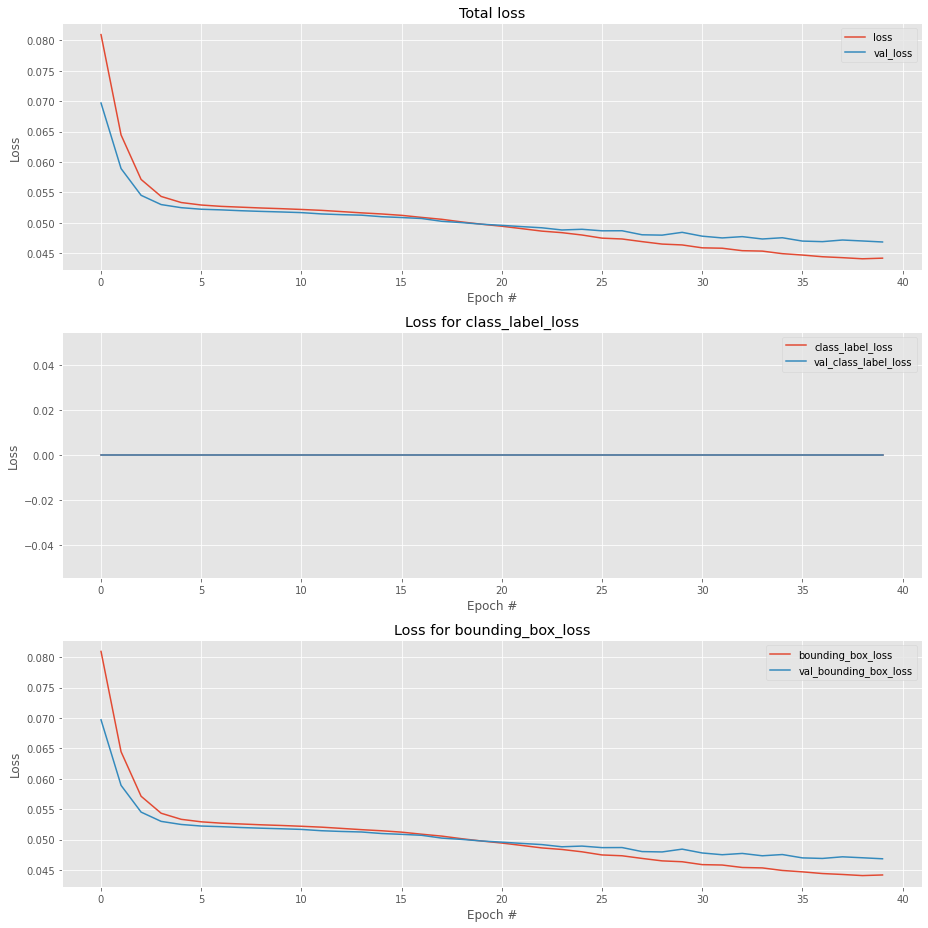

In [36]:
# plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()
# save the losses figure and create a new figure for the accuracies
plt.tight_layout()
plt.show()